In [7]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [8]:
from neurovis import NeuroVis

# Reproduce a figure from a published article with a public dataset

### This article:
 Nuo Li, Tsai-Wen Chen, Zengcai V. Guo, Charles R. Gerfen & Karel Svoboda.   A motor cortex circuit for motor planning and movement.  Nature 519, 51–56 (05 March 2015) PMID: 25731172 doi: 10.1038/nature14178 [[link to paper](http://www.nature.com/nature/journal/v519/n7541/full/nature14178.html)]

### Has a publicly available dataset on CRCNS.org:
 Nuo Li, Charles R Gerfen, Karel Svoboda (2014); Extracellular recordings from anterior lateral motor cortex (ALM) neurons of adult mice performing a tactile decision behavior. CRCNS.org [[link to dataset](https://crcns.org/data-sets/motor-cortex/alm-1)]


### Here's Figure 2:

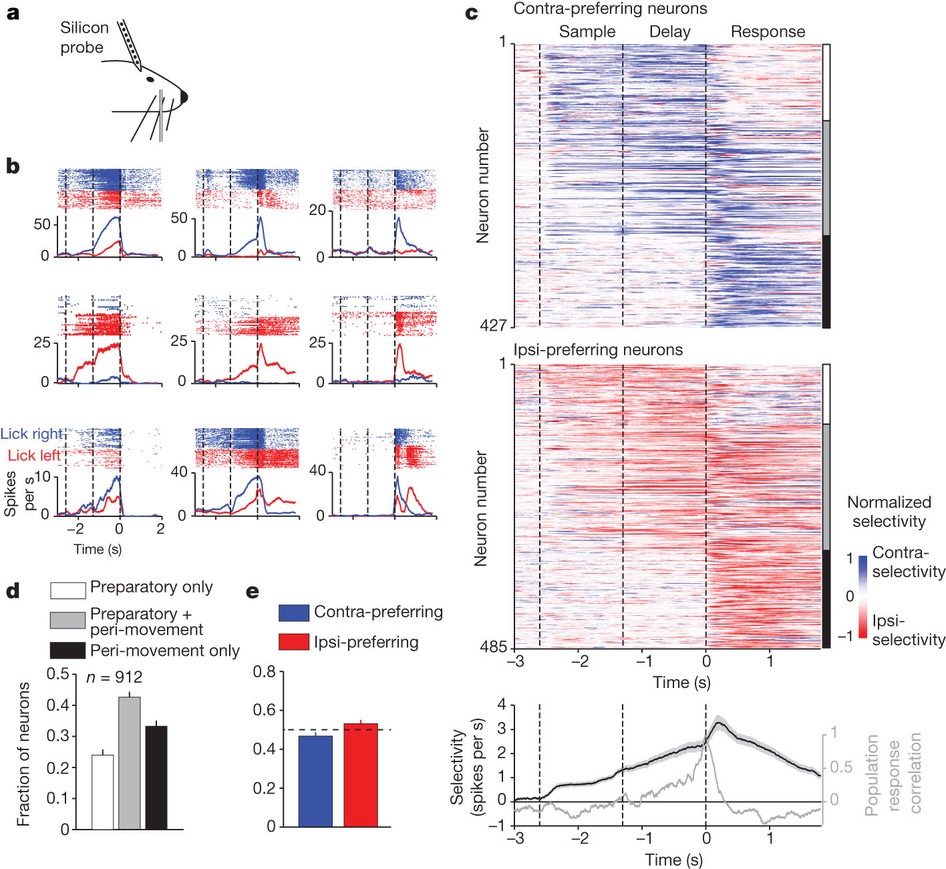

In [9]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(filename="./figures/nature14178-f2.jpg", width=650)

# Let's reproduce the first panel of Figure 2b

#### We will need the data for neuron `9` of session `ANM218457_20131006`

## 0. Download data

#### 0.1. Register in `CRCNS` [[link to request account](https://crcns.org/request-account)]
#### 0.2. Download file `data_structure_ANM218457.tar.gz` [[link](https://portal.nersc.gov/project/crcns/download/alm-1/datafiles/data_structure_files)]
#### 0.3. Unzip it and you will find file `data_structure_ANM218457_20131006.mat`

## 1. Load data

In [10]:
import scipy.io
mat = scipy.io.loadmat('data_structure_ANM218457_20131006')

## 2. Get spike times

In [11]:
neuron_n = 9
spike_times = mat['obj']['eventSeriesHash'][0][0]['value'][0][0][0][neuron_n-1][0][0][1]
spike_times = [i[0] for i in spike_times]

# instantiate neuron
neuron = NeuroVis(spike_times, neuron_n)
print 'neuron %d has a firing rate of %0.2f spikes per second' % (neuron_n, neuron.firingrate)

neuron 9 has a firing rate of 5.07 spikes per second


## 3. Get event times

In [29]:
events = pd.DataFrame()
events['trialStart'] = mat['obj']['trialStartTimes'][0][0][0]
events['cueTimes'] = np.squeeze(mat['obj']['trialPropertiesHash'][0][0][0][0][2][0][2])
events['RealCueTimes'] = events['trialStart'] + events['cueTimes']
#events['trial_id'] = np.arange(np.size(events['trialStart']))
events.head()

,trialStart,cueTimes,RealCueTimes
0,2.261389,0.000000,2.261389
1,437.238815,5.784644,443.023459
2,448.597437,3.172654,451.770091
3,457.379402,7.776468,465.155870
4,470.885681,3.322320,474.208001


## 4. Get features

In [30]:
features = pd.DataFrame()

trialTypeMat = mat['obj']['trialTypeMat'][0][0].astype(np.bool_)
trialTypeStr = np.squeeze(np.stack(np.squeeze(mat['obj']['trialTypeStr'][0][0])))

for ind, feat in enumerate(trialTypeStr):
    features[str(feat)] = trialTypeMat[ind]

features['GoodTrials'] = np.squeeze(mat['obj']['trialPropertiesHash'][0][0][0][0][2][0][3]).astype(np.bool_)
#features['trial_id'] = np.arange(np.size(features['GoodTrials']))
features.head()

,HitR,HitL,ErrR,ErrL,NoLickR,NoLickL,LickEarly,StimTrials,GoodTrials
0,False,False,False,False,False,False,False,False,True
1,True,False,False,False,False,False,True,True,True
2,True,False,False,False,False,False,False,True,True
3,True,False,False,False,False,False,True,True,True
4,False,False,False,True,False,False,True,True,True


## 5. Define some tidy features

In [31]:
var_of_int = ['HitR','HitL', 'ErrR', 'ErrL']

features['response'] = features[var_of_int].apply(lambda row: row.argmax() if row.max()==True else '',axis=1)
features['correct'] = features['response'].map(lambda s: {'Hit':True,'Err':False,'':np.nan}[s[:3]])
features['response'] = features['response'].map(lambda s: {'L':'Lick left','R':'Lick right','':''}[s[-1:]])

features.head()

,HitR,HitL,ErrR,ErrL,NoLickR,NoLickL,LickEarly,StimTrials,GoodTrials,response,correct
0,False,False,False,False,False,False,False,False,True,,NaN
1,True,False,False,False,False,False,True,True,True,Lick right,True
2,True,False,False,False,False,False,False,True,True,Lick right,True
3,True,False,False,False,False,False,True,True,True,Lick right,True
4,False,False,False,True,False,False,True,True,True,Lick left,False


In [33]:
events_var = ['RealCueTimes']#, 'trial_id']
features_var = ['GoodTrials', 'response', 'correct']#, 'trial_id']
#data_df = pd.merge(events[events_var], features[features_var], on='trial_id')
data_df = pd.concat([events[events_var], features[features_var]], axis=1)
data_df.head(10)

,RealCueTimes,GoodTrials,response,correct
0,2.261389,True,,NaN
1,443.023459,True,Lick right,True
2,451.770091,True,Lick right,True
3,465.155870,True,Lick right,True
4,474.208001,True,Lick left,False
5,488.641777,True,Lick left,False
6,505.370376,True,Lick left,False
7,519.462653,True,Lick left,False
8,535.032091,True,Lick left,True
9,544.174388,True,Lick left,True


 ## 6. Plot PSTH and Raster plots

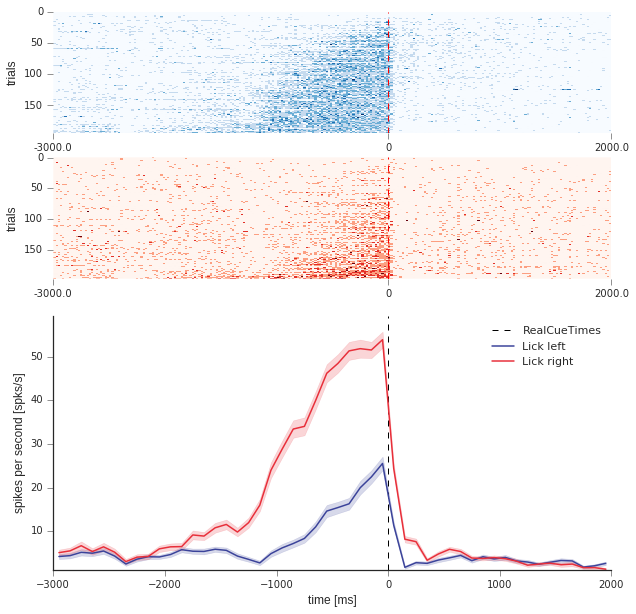

In [34]:
plt.style.use('seaborn-ticks')
window = [-3000,2000]
cmap = [plt.get_cmap('Blues'), plt.get_cmap('Reds')]
colors=['#3B439A', '#E82F3A']


#get rasters------------------------------------------------------
rasters_fig2b1 = neuron.get_raster(event='RealCueTimes',
                                   data = data_df,
                                   conditions = 'response',
                                   window=window,
                                   binsize=20,
                                   plot=False);



plt.figure(figsize=(10,10))

#plot rasters-------------------------------------------------------
for i, cond in enumerate(rasters_fig2b1['conditions'][::-1]):
    plt.subplot(4,1,i+1)
    neuron.plot_raster(rasters=rasters_fig2b1,
                       condition=cond,
                       cmap=[cmap[i]],
                       condition_names=rasters_fig2b1['conditions'],
                       sort=True,
                       has_title=False)
    plt.xlabel('')
    
    
    
plt.subplot(212)
neuron.get_psth(event='RealCueTimes',
                data = data_df,
                conditions = 'response',
                window=window,
                binsize=100,
                plot=True,
                colors=['#3B439A', '#E82F3A']);
plt.title('')
plt.show()

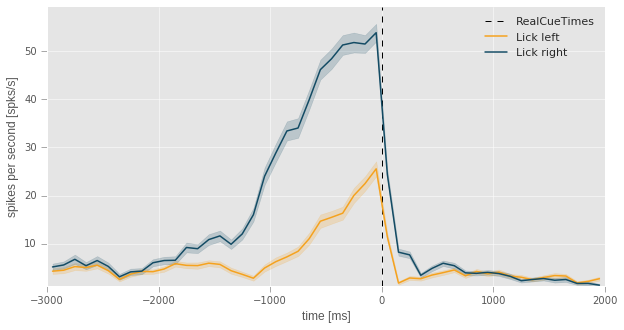

In [28]:
plt.style.use('ggplot')

plt.figure(figsize=(10,5))
neuron.get_psth(event='RealCueTimes',
                data = data_df,
                conditions = 'response',
                window=window,
                binsize=100,
                plot=True);
plt.title('')
plt.show()